# Improving `Hateful Memes` Identification With `Ensemble Learning` 🤗

This Notebook is the core of our EE-559 Group Mini Project. Our GitHub repository can be found at [DeepLearning_HateSpeech](https://github.com/PatateMagique/DeepLearning_HateSpeech).
In the following work we will study the potential benefits of using Ensemble Learning for improving the accuracy of 3 different state-of-the-art models for Hateful Memes detection (binary classification, label 0 = not harmful, label 1 = harmful)

The dataset we are using for this work is provided by Facebook and can be downloaded [here](https://hatefulmemeschallenge.com). Please fill n/a in the affiliation field, otherwise the download will fail.

The behavior of this Notebook is controlled by a few global variables, allowing the user to easily chose which models/topics to use, or activate/deactivate features like training or overwritting weights.

Running the cells of this Notebook in sequential order, will:

1) generate (if activated) custom .jsonl files for training, validation and testing
2) create an initialize up to 12 models, depending on the settings chosen
3) train those models and save the weights and the plots if requested, or load pretrained weights from a local folder
4) test the performances of those models on different testing sets
5) create and test the Ensemble Learning pipeline

## 1. Seting up the environment

Let's start by importing the required dependencies.

In [1]:
import os
import sys 
import torch
import platform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Importing the custom modules
import custom_library as cl
from topic_list import count_keywords, create_class_files, load_data

Then we chose the optimal computation configuration depending on the operatin system.

In [2]:
# Check python version is at least python 3.9
assert (sys.version_info.major == 3) and (sys.version_info.minor > 9)

# Get os name
os_name = platform.system().lower()

# OS X
if 'darwin' in os_name:
    num_workers = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Set the device to mps (Apple Silicon GPU) if availaible for faster computation
    print("Detected OS X, device set to:", device)
# Linux 
elif 'linux' in os_name:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device to cuda (NVIDIA GPU) if availaible for faster computation
    num_workers = 0
    print("Detected Linux, device set to:", device) 
# Windows 
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device to cuda (NVIDIA GPU) if availaible for faster computation
    num_workers = 0
    print("Detected Windows, device set to:", device)

Detected OS X, device set to: mps


Now we can setup the paths to our data, and set the global variables used for controlling the bahavior of the Notebook. Please make sure you have the correct file structure:

```code
.
└── DeepLearning_HateSpeech/
    ├── ALIGN
    ├── BLIP
    ├── CLIP
    ├── hateful_memes/
    │   ├── img/
    │   │   └── ...
    │   ├── dev_seen.jsonl
    │   ├── dev_unseen.jsonl
    │   ├── test_seen.jsonl
    │   ├── test_unseen.jsonl
    │   └── train.jsonl
    ├── Scitas/
    │   └── job_script.sh
    ├── VBERT/
    │   └── image_captioning_vbert.ipynb
    ├── custom_library.py
    ├── Detecting Hate Speech in Multimodal Memes.pdf
    ├── main.ipynb
    └── README.md
```

In [3]:
# Define the directory paths
destination_dir  = "hateful_memes/"
train_json       = "hateful_memes/train.jsonl"
test_seen_json   = "hateful_memes/test_seen.jsonl"
test_unseen_json = "hateful_memes/test_unseen.jsonl"
img_path         = 'hateful_memes/img'

# Define the global variables for tunning the behavior of the notebook, to allow faster testing of the differents steps
generate_new_files = False    # Flag to decide if new customs .jsonl files should be created/overwritten
model_selection = ['BLIP']    # List to decide which model to use. Options: ['CLIP', 'BLIP', 'ALIGN']
topic_selection = ['Base', 'Africans', 'Womens', 'Muslims']   # List to decide which topics to use. Options: ['Base', 'Africans', 'Womens', 'Muslims']
over_writing_models = []  # List to decide which already saved weights and plots should be overwritten
training_active = False       # Flag to activate or deactivate training
plot_training = True          # Flag to activate the plotting of the training
testing_performances = False  # Flag to activate the testing of the models
test_model_on_images = False   # Flag to activate the testing of the models on set of 4 random test images
ensemble_active = True        # Flag to activate the ensemble of the models

## 2. Generation of the custom datasets

First, let's search for the populations that are the most frequently represented and targetted by the memes in the dataset. In this project we will now refer to a population as a topic. We define a function that will count the number of occurences of each keyword associated with a topic in the dataset. The harm rate is defined as the ratio between the number of harmful memes related to a topic and the total number of memes in the set. 

In [4]:
keywords = {
    "Africans" : ["ni99ers", "niggers", "nigger", "africa", "racists", "slaves", "color", "blacks", "colors", "racist", "black", "african", "slave", "slavery", "cotton"],
    "Womens"   : ["dishwasher", "prostitutes", "prostitute", "ladies", "bitches", "daughters", "girls", "mothers", "feminists", "sisters", "wifes", "wife", "sister", "mum", "feminist", "daughter", "mother", "kitchen", "bitch", "slut", "woman", "female", "lady", "girl",  "women", "feminism", "sexism", "gender"],
    "Muslims"  : ["mohamed", "muslims", "religion", "allah", "quran", "sharia", "radical", "jihad", "burqa", "terrorism", "muslim", "arab", "islam", "islamic", "muslimah", "hijab",  "shiite", "halal", "mosque", "goat", "habibi"],
    "LGBTQ"    : ["sexual", "lesbians", "gays", "homophobia", "lgbtq", "lgbt", "gay", "homo", "lesbian", "bisexual", "transgender", "queer", "pride",  "drag", "trans", "nonbinary"],
    "Jews"     : ["auschwitz", "Israel", "jewish", "jew", "hebrew", "israeli", "holla", "gas", "bank"],
    "Politics" : ["activist", "protest", "demonstration", "rally", "activism", "campaign", "cause", "resist", "justice", "rights"],
    "Asians"   : ["asian", "chinese", "oriental", "eastasian", "japanese", "korean", "vietnamese", "filipino", "anime", "manga"],
    "Disable"  : ["vegetable", "disabled", "retarded", "handicap", "disability", "impaired", "specialneeds", "wheelchair", "autism", "dyslexia"],
    "Homeless" : ["homeless", "poor", "beggar", "vagrant", "homelessness", "poverty", "shelter", "unemployed", "panhandler"],
    "Natives " : ["indigenous", "nativeamerican", "firstnations", "aboriginal", "tribal", "native", "reservation", "tribe"],
    "Latinos " : ["latino", "hispanic", "chicano", "mestizo", "latina", "latinx", "boricua", "tejano"],
}

count_keywords(train_json, keywords, verbosity = 1);
count_keywords(test_unseen_json, keywords, verbosity = 1);

File: train.jsonl - Total Memes: 8500
Africans:  593  Harm Rate:  4.53%  Label 0:  208  Label 1:  385
Womens  :  705  Harm Rate:  3.91%  Label 0:  373  Label 1:  332
Muslims :  656  Harm Rate:  4.95%  Label 0:  235  Label 1:  421
LGBTQ   :  183  Harm Rate:  1.55%  Label 0:  51   Label 1:  132
Jews    :  177  Harm Rate:  1.38%  Label 0:  60   Label 1:  117
Politics:  62   Harm Rate:  0.29%  Label 0:  37   Label 1:  25
Asians  :  60   Harm Rate:  0.45%  Label 0:  22   Label 1:  38
Disable :  54   Harm Rate:  0.46%  Label 0:  15   Label 1:  39
Homeless:  31   Harm Rate:  0.14%  Label 0:  19   Label 1:  12
Natives :  15   Harm Rate:  0.05%  Label 0:  11   Label 1:  4
Latinos :  1    Harm Rate:  0.01%  Label 0:  0    Label 1:  1
File: test_unseen.jsonl - Total Memes: 2000
Africans:  71   Harm Rate:  1.95%  Label 0:  32   Label 1:  39
Womens  :  144  Harm Rate:  3.00%  Label 0:  84   Label 1:  60
Muslims :  93   Harm Rate:  2.10%  Label 0:  51   Label 1:  42
LGBTQ   :  25   Harm Rate:  0.60%

We set the minimum number of memes for a topic to become a class to 300, in order to have sufficiently large sets. Thus, only the topics "African", "Womens" and "Muslims" are kept as class. We can now generate new custom .jsonl files. 

Creating such file ivolve several steps, performed in the function create_class_files for every topic:

1) Get all the memes from the original train set that contain a keyword from the topic
2) Check it there are more than 300 memes associated with the topic
3) If yes, add a similar amount of memes that do not include keyword related to the topic (double the size of the set)
4) Force to 0 the labels of all memes that do not belong to the topic. Only the memes harmful and belonging to current topic remained labeled as 1.
5) Shuffle the memes in this new set
6) Exctract 80% for the new validation set
7) Write and save the new sets

We are also defining the topic "Base". The train set of "Base" which is a set obtained by merging together the train sets of our 3 class. This topic will be used to train our BASE models and give us our performance baseline, to which we will compare our Ensemble approach.

In [5]:
if generate_new_files:
    create_class_files(train_json, count_keywords(train_json, keywords, verbosity = 0), destination_dir, "train"); # Create the custom .jsonl files for the training and validation
    create_class_files(test_unseen_json, count_keywords(test_unseen_json, keywords, verbosity = 0), destination_dir, "test"); # Create the custom .jsonl files for the testing

We can re-run the count_keywords function to have an idea of the new datatsets composition:

In [6]:
refined_keywords = { "Africans" : ["black", "white", "afro", "african", "ebony", "panafrican", "afroamerican", "nubian", "melanin", "slave", "slavery", "field", "cotton"],
                     "Womens"  : ["woman", "she", "her", "female", "feminine", "lady", "girl", "feminist", "queen", "mother", "daughter"],
                     "Muslims" : ["muslim", "arab", "coran", "islam", "islamic", "muslimah", "hijab", "sunni", "shiite", "halal", "mosque", "goat", "habibi"], }

count_keywords("hateful_memes/Base_train.jsonl", refined_keywords, verbosity = 1);
count_keywords("hateful_memes/Base_test.jsonl", refined_keywords, verbosity = 1);

count_keywords("hateful_memes/Africans_train.jsonl", {"Africans":refined_keywords["Africans"]}, verbosity = 1);
count_keywords("hateful_memes/Africans_val.jsonl", {"Africans":refined_keywords["Africans"]}, verbosity = 1);
count_keywords("hateful_memes/Africans_test.jsonl", {"Africans":refined_keywords["Africans"]}, verbosity = 1);

count_keywords("hateful_memes/Womens_train.jsonl", {"Womens":refined_keywords["Womens"]}, verbosity = 1);
count_keywords("hateful_memes/Womens_val.jsonl", {"Womens":refined_keywords["Womens"]}, verbosity = 1);
count_keywords("hateful_memes/Womens_test.jsonl", {"Womens":refined_keywords["Womens"]}, verbosity = 1);

count_keywords("hateful_memes/Muslims_train.jsonl", {"Muslims":refined_keywords["Muslims"]}, verbosity = 1);
count_keywords("hateful_memes/Muslims_val.jsonl", {"Muslims":refined_keywords["Muslims"]}, verbosity = 1);
count_keywords("hateful_memes/Muslims_test.jsonl", {"Muslims":refined_keywords["Muslims"]}, verbosity = 1);

File: Base_train.jsonl - Total Memes: 2802
Africans:  420  Harm Rate:  7.03%  Label 0:  223  Label 1:  197
Womens  :  292  Harm Rate:  3.75%  Label 0:  187  Label 1:  105
Muslims :  352  Harm Rate:  6.96%  Label 0:  157  Label 1:  195
File: Base_test.jsonl - Total Memes: 697
Africans:  66   Harm Rate:  4.45%  Label 0:  35   Label 1:  31
Womens  :  61   Harm Rate:  2.44%  Label 0:  44   Label 1:  17
Muslims :  61   Harm Rate:  3.87%  Label 0:  34   Label 1:  27
File: Africans_train.jsonl - Total Memes: 948
Africans:  357  Harm Rate:  25.11%  Label 0:  119  Label 1:  238
File: Africans_val.jsonl - Total Memes: 238
Africans:  96   Harm Rate:  25.21%  Label 0:  36   Label 1:  60
File: Africans_test.jsonl - Total Memes: 142
Africans:  60   Harm Rate:  24.65%  Label 0:  25   Label 1:  35
File: Womens_train.jsonl - Total Memes: 1128
Womens  :  258  Harm Rate:  9.84%  Label 0:  147  Label 1:  111
File: Womens_val.jsonl - Total Memes: 282
Womens  :  55   Harm Rate:  5.32%  Label 0:  40   Label 

## 3. Loading the customs datasets

Let's load the memes, with their labels and caption.

In [7]:
topics = ['Base', 'Africans', 'Womens', 'Muslims']
models = ['CLIP', 'BLIP', 'ALIGN']

train_list_B, validation_list_B, test_list_B = [], [], []
train_list_A, validation_list_A, test_list_A = [], [], []
train_list_W, validation_list_W, test_list_W = [], [], []
train_list_M, validation_list_M, test_list_M = [], [], []

for topic in topics: 
    train_json_path      = f'hateful_memes/{topic}_train.jsonl'
    validation_json_path = f'hateful_memes/{topic}_val.jsonl'
    test_json_path       = f'hateful_memes/{topic}_test.jsonl'

    # Get the first letter of the topic
    topic_initial = topic[0]

    # Use locals to access the correct list based on the topic
    load_data(train_json_path, locals()[f'train_list_{topic_initial}'], img_path)
    load_data(validation_json_path, locals()[f'validation_list_{topic_initial}'], img_path)
    load_data(test_json_path, locals()[f'test_list_{topic_initial}'], img_path)

Loaded 2802 memes from Base_train.jsonl
Loaded 701 memes from Base_val.jsonl
Loaded 697 memes from Base_test.jsonl
Loaded 948 memes from Africans_train.jsonl
Loaded 238 memes from Africans_val.jsonl
Loaded 142 memes from Africans_test.jsonl
Loaded 1128 memes from Womens_train.jsonl
Loaded 282 memes from Womens_val.jsonl
Loaded 288 memes from Womens_test.jsonl
Loaded 1049 memes from Muslims_train.jsonl
Loaded 263 memes from Muslims_val.jsonl
Loaded 186 memes from Muslims_test.jsonl


We can display as an example the caption, label and the corresponding image for 1 meme from the custom train set of each of our topics:

Topic: Base - Caption: rev al sharpton that gorilla was 17 black and unarmed - Label: 1
Topic: Africans - Caption: how black people fight here how black people fight there - Label: 0
Topic: Womens - Caption: me cis girls - Label: 0
Topic: Muslims - Caption: did you buy your stupidity or you got it for free - Label: 0


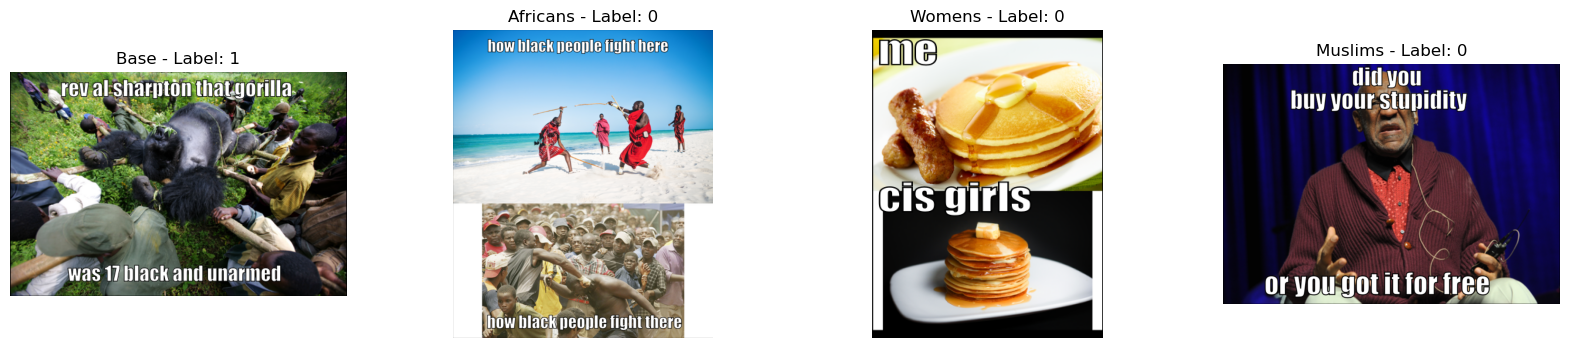

In [8]:
fig, axs = plt.subplots(1, len(topics), figsize=(20, 4))

for i, topic in enumerate(topics): 
    topic_initial = topic[0]
    print(f"Topic: {topic} - Caption: {locals()[f'train_list_{topic_initial}'][0]["text"]} - Label: {locals()[f'train_list_{topic_initial}'][0]["label"]}")
    axs[i].imshow(locals()[f'train_list_{topic_initial}'][0]["image"])
    axs[i].set_title(f"{topic} - Label: {locals()[f'train_list_{topic_initial}'][0]['label']}")
    axs[i].axis('off')

plt.show()

## 4. Initialization of the models

This cell create the models depending on the parameters set above, creating at most 12 models (4 CLIP, 4 BLIP & 4 ALIGN).

In [9]:
CLIP_A, CLIP_A, CLIP_W, CLIP_M     = None, None, None, None
BLIP_B, BLIP_A, BLIP_W, BLIP_M     = None, None, None, None
ALIGN_B, ALIGN_A, ALIGN_W, ALIGN_M = None, None, None, None
CLIP_processor, BLIP_processor, ALIGN_processor = None, None, None

for model in model_selection:
    print(f"Creating {model} models...")

    if model == 'CLIP':

        from transformers import CLIPModel, CLIPProcessor

        for topic in topic_selection:
            topic_initial = topic[0]

            # Create a pretrained CLIP model and its processor
            locals()[f'CLIP_{topic_initial}'] = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
            CLIP_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
            # Add a classification head to the model
            locals()[f'CLIP_{topic_initial}'] = cl.create_model(model_name=model, model=locals()[f'CLIP_{topic_initial}'], topic_initial=topic_initial, device=device)
    
    elif model == 'BLIP':
            
        from transformers import BlipForConditionalGeneration, AutoProcessor

        for topic in topic_selection:
            topic_initial = topic[0]
            
            # Create a pretrained BLIP model and its processor
            locals()[f'BLIP_{topic_initial}'] = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
            BLIP_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
            # Add a classification head to the model
            locals()[f'BLIP_{topic_initial}'] = cl.create_model(model_name=model, model=locals()[f'BLIP_{topic_initial}'], topic_initial=topic_initial, device=device)
    
    elif model == 'ALIGN':

        from transformers import AlignModel, AlignProcessor

        for topic in topic_selection:
            topic_initial = topic[0]

            # Create a pretrained ALIGN model and its processor
            locals()[f'ALIGN_{topic_initial}'] = AlignModel.from_pretrained("kakaobrain/align-base")
            ALIGN_processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
            # Add a classification head to the model
            locals()[f'ALIGN_{topic_initial}'] = cl.create_model(model_name=model, model=locals()[f'ALIGN_{topic_initial}'], topic_initial=topic_initial, device=device)

## 5. Creation of the Datasets and Dataloaders

Now that we have loaded the models and their processor, let's load the datasets and the dataloaders:

In [10]:
CLIP_train_loader_B, CLIP_validation_loader_B, CLIP_test_loader_B = None, None, None
CLIP_train_loader_A, CLIP_validation_loader_A, CLIP_test_loader_A = None, None, None
CLIP_train_loader_W, CLIP_validation_loader_W, CLIP_test_loader_W = None, None, None
CLIP_train_loader_M, CLIP_validation_loader_M, CLIP_test_loader_M = None, None, None

BLIP_train_loader_B, BLIP_validation_loader_B, BLIP_test_loader_B = None, None, None
BLIP_train_loader_A, BLIP_validation_loader_A, BLIP_test_loader_A = None, None, None
BLIP_train_loader_W, BLIP_validation_loader_W, BLIP_test_loader_W = None, None, None
BLIP_train_loader_M, BLIP_validation_loader_M, BLIP_test_loader_M = None, None, None

ALIGN_train_loader_B, ALIGN_validation_loader_B, ALIGN_test_loader_B = None, None, None
ALIGN_train_loader_A, ALIGN_validation_loader_A, ALIGN_test_loader_A = None, None, None
ALIGN_train_loader_W, ALIGN_validation_loader_W, ALIGN_test_loader_W = None, None, None
ALIGN_train_loader_M, ALIGN_validation_loader_M, ALIGN_test_loader_M = None, None, None

for model in model_selection:
    for topic in topics:
        
        topic_initial = topic[0]
        # Build the datasets
        train_dataset      = cl.ImageCaptioningDataset(locals()[f'train_list_{topic_initial}'], locals()[f'{model}_processor'])
        validation_dataset = cl.ImageCaptioningDataset(locals()[f'validation_list_{topic_initial}'], locals()[f'{model}_processor'])
        test_dataset       = cl.ImageCaptioningDataset(locals()[f'test_list_{topic_initial}'], locals()[f'{model}_processor'])

        # Create the loaders
        locals()[f'{model}_train_loader_{topic_initial}']      = DataLoader(train_dataset,      batch_size=32, shuffle=True,  num_workers=num_workers, collate_fn = cl.collate_fn)
        locals()[f'{model}_validation_loader_{topic_initial}'] = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=num_workers, collate_fn = cl.collate_fn)
        locals()[f'{model}_test_loader_{topic_initial}']       = DataLoader(test_dataset,       batch_size=32, shuffle=False, num_workers=num_workers, collate_fn = cl.collate_fn)

    print(f"Succesfully created loaders for model {model}.")

Succesfully created loaders for model BLIP.


## 6. Training the models

Let's train our models! Run the simply the cell below to train them. The user can safely stop the training at anytime after the second epoch if needed, without losing any progress. The resulting trained model will be the best version of itself obtained before the user interruption.

In [11]:
best_model, best_f1, best_epoch, val_accs, val_loss, train_loss = None, None, None, None, None, None

try:
    for model in model_selection:
        for topic in topic_selection:
            topic_initial = topic[0]
            if training_active:
                
                locals()[f'{model}_{topic_initial}'].train() # Set the model to training mode

                # Hyperparameters: 
                if model == 'CLIP':
                    optimizer = torch.optim.AdamW(locals()[f'{model}_{topic_initial}'].parameters(), lr=5e-5)
                elif model == 'Align':
                    optimizer = torch.optim.AdamW(locals()[f'{model}_{topic_initial}'].parameters(), lr=5e-5)
                else:
                    optimizer = torch.optim.AdamW(locals()[f'{model}_{topic_initial}'].parameters(), lr=5e-6)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
                epochs = 7

                print(f"Training {model}_{topic_initial} for {epochs} epochs...")
                best_model, best_f1, best_epoch, val_accs, val_loss, train_loss = cl.train(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_train_loader_{topic_initial}'], locals()[f'{model}_validation_loader_{topic_initial}'], n_epochs=epochs, optimizer=optimizer, device=device, scheduler=scheduler)
                print(f"Best {model}_{topic_initial} at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

                if plot_training:
                    cl.plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss, model_name=f'{model}_{topic_initial}')
                    if f'{topic}' in over_writing_models:
                        plt.savefig(f'{model}/{model}_{topic_initial}_training.png')       # save the plot
                if f'{topic}' in over_writing_models:
                    torch.save(best_model, f'{model}/{model}_{topic_initial}_trained.pth') # Save the state dictionary
                    locals()[f'{model}_{topic_initial}'].eval();                           # Set the model to evaluation mode
                    print(f"Saved {model}_{topic_initial}.")

            else:
                # Check if the file exists before trying to load it
                if os.path.exists(f'{model}/{model}_{topic_initial}_trained.pth'):
                    if model == 'CLIP':
                        locals()[f'CLIP_{topic_initial}'] = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
                        locals()[f'CLIP_{topic_initial}'] = cl.ModelForClassification(locals()[f'CLIP_{topic_initial}'])
                    elif model == 'BLIP':
                        locals()[f'BLIP_{topic_initial}'] = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
                        locals()[f'BLIP_{topic_initial}'] = cl.create_model(model_name=model, model=locals()[f'BLIP_{topic_initial}'], topic_initial=topic_initial, device=device)
                    elif model == 'ALIGN':
                        locals()[f'ALIGN_{topic_initial}'] = AlignModel.from_pretrained("kakaobrain/align-base")
                        locals()[f'ALIGN_{topic_initial}'] = cl.ModelForClassification(locals()[f'ALIGN_{topic_initial}'])
                    locals()[f'{model}_{topic_initial}'].load_state_dict(torch.load(f'{model}/{model}_{topic_initial}_trained.pth', map_location=device)) # Load the state_dict
                    locals()[f'{model}_{topic_initial}'].eval();                                                                     # Set the model to evaluation mode
                    locals()[f'{model}_{topic_initial}'] = locals()[f'{model}_{topic_initial}'].to(device)    
                    print(f"Succesfully loaded saved weights for {model}_{topic_initial}.")
                else:
                    print(f"No pre-trained model found for {model}_{topic_initial}.")
                    locals()[f'{model}_{topic_initial}'] = None
except KeyboardInterrupt:
    print(f"Best {model}_{topic_initial} at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")
    if plot_training:
        plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss, model_name=f'{model}_{topic_initial}')
        if f'{model}_{topic_initial}' in over_writing_models:
            plt.savefig(f'{model}/{model}_{topic_initial}_training.png') # save the plot
    if f'{model}_{topic_initial}' in over_writing_models:
        print(f"Saving {model}_{topic_initial} and outputs...")
        torch.save(best_model, f'{model}_{topic_initial}_trained.pth') # Save the state dictionary
        locals()[f'{model}_{topic_initial}'].eval();                   # Set the model to evaluation mode

NameError: name 'BlipForConditionalGeneration' is not defined

## 7. Testing the models and inferences

Let's check the results on our custom unseen test sets:

In [ ]:
CLIP_confidences_A, CLIP_confidences_B, CLIP_confidences_W, CLIP_confidences_M = [], [], [], []
BLIP_confidences_A, BLIP_confidences_B, BLIP_confidences_W, BLIP_confidences_M = [], [], [], []
ALIGN_confidences_A, ALIGN_confidences_B, ALIGN_confidences_W, ALIGN_confidences_M = [], [], [], []
f1_Base, f1_Ensemble = None, None

for model in model_selection:
    for topic in topic_selection:
        topic_initial = topic[0]
        # check that the model is loaded correctly
        if locals()[f'{model}_{topic_initial}'] is not None:
            if topic == 'Base':
                f1_Base, loss, locals()[f'{model}_confidences_{topic_initial}'] = cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_test_loader_B'], device, return_confidences=True)
                print(f"{model}_{topic_initial} F1 score on the unseen Base_test set: {100*f1_Base:.2f}% ----------------------")
                if testing_performances:
                    print(f"{model}_{topic_initial} F1 score on the Base_train set: {100*cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_train_loader_{topic_initial}'], device)[0]:.2f}%")
                    print(f"{model}_{topic_initial} F1 score on the Base_val set: {100*cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_validation_loader_{topic_initial}'], device)[0]:.2f}%")
            else:
                f1, loss, locals()[f'{model}_confidences_{topic_initial}'] = cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_test_loader_B'], device, return_confidences=True)
                print(f"{model}_{topic_initial} F1 score on the unseen Base test set: {100*f1:.2f}% ----------------------")
                if testing_performances:
                    print(f"{model}_{topic_initial} F1 score on the {topic}_train set: {100*cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_train_loader_{topic_initial}'], device)[0]:.2f}%")
                    print(f"{model}_{topic_initial} F1 score on the {topic}_val set: {100*cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_validation_loader_{topic_initial}'], device)[0]:.2f}%")
                    print(f"{model}_{topic_initial} F1 score on the {topic}_test set: {100*cl.test(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_test_loader_{topic_initial}'], device)[0]:.2f}%")

We can test our performances on set of 4 random unseen test images, in order to have a neat visualisation.

In [ ]:
test_model_on_images = True
if test_model_on_images:
    for model in model_selection:
        for topic in topic_selection:
            topic_initial = topic[0]
            # check that the model is loaded correctly
            if locals()[f'{model}_{topic_initial}'] is not None:
                cl.predict_image2(locals()[f'{model}_{topic_initial}'], locals()[f'{model}_test_loader_{topic_initial}'], device, index=np.random.randint(0, 27), model_name = model, topic_name = topic_initial)

## 8. Ensemble Learning implementation

In [ ]:
if ensemble_active:
    # Get ensemble predictions for the CLIP models trained on datasets A, W, and M
    ensemble_predictions = cl.get_ensemble_predictions(BLIP_confidences_A, BLIP_confidences_W, BLIP_confidences_M)
    # Calculate F1 scores
    f1_ensemble = cl.test_ensemble(locals()[f'BLIP_test_loader_B'], ensemble_predictions)

    print(f"F1 score for CLIP model trained on base dataset: {100*f1_Base:.2f}%")
    print(f"F1 score for ensemble of CLIP models trained on A, W, and M: {100*f1_ensemble:.2f}%")

## 9. Results and Conclusion